<a href="https://colab.research.google.com/github/scigeek72/GNN_Repo/blob/main/Predicting_Drug_Drug_Interactions_using_Graph_Neural%C2%A0Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Drug-Drug Interactions using Graph Neural Networks

---

By Ananth Agarwal, Meg Richey, and Zeb Mehring as part of the Stanford CS 224W Fall 2021 course project.

N.B. Follow along with the companion [Medium article](https://medium.com/stanford-cs224w/predicting-drug-drug-interactions-using-graph-neural-networks-6a093cc59a33)


Taking certain combinations of prescription drugs can be unsafe if the drugs interact with each other. Medical professionals and patients rely on drug-drug interaction databases to make safe medical decisions. In this Colab, we will learn about Graph Neural Networks and how we can train a model to predict whether two drugs will interact with each other.

Outline:
* Loading the drug-drug interaction graph from Open Graph Benchmark (OGB)
* Defining our first Graph Neural Network (GNN) model: GraphSAGE
* Exploring defining a modification to the traditional GraphSAGE operator

# Device
We recommend using a GPU for this Colab.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

# Installation

In [ ]:
# Install torch geometric
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install ogb

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html
     |████████████████████████████████| 7.9 MB 575 kB/s 
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html
     |████████████████████████████████| 3.5 MB 5.4 MB/s 
     |████████████████████████████████| 370 kB 5.2 MB/s 
     |████████████████████████████████| 482 kB 41.9 MB/s 
     |████████████████████████████████| 41 kB 521 kB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.3-py3-none-any.whl size=581969 sha256=6dc6a1c439fa16312c3c0717f8b06f72c7eb2212c3dc152d53c5b9621adc9f18
  Stored in directory: /root/.cache/pip/wheels/c3/2a/58/87ce0508964d4def1aafb92750c4f3ac77038efd1b9a89dcf5
Successfully built torch-geometric
     |████████████████████████████████| 78 kB 3.5 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=abdd2c76a99a781169c3b5a5b97f6bd4fc9ce0fbeef5828c90ef13fc64aa6c36
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd

In [ ]:
# Imports
import torch
import torch_geometric
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import negative_sampling
from tqdm import trange

Setup using GPU:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# OGB Drug-Drug Interaction Dataset

We will be using the [PyTorch Geometric library (PyG)](https://github.com/pyg-team/pytorch_geometric) throughout this Colab. PyTorch Geometric is built on top of PyTorch to simplify implementation of Graph Neural Networks, which we will cover in-depth. 
The drug-drug interaction (DDI) dataset **ogbl-ddi** is provided by **[Open Graph Benchmark (OGB)](https://ogb.stanford.edu/)**, which provides datasets for a variety of Graph ML tasks. ogbl-ddi is a link prediction dataset [1].

Following the example from the [OGB website](https://ogb.stanford.edu/docs/linkprop/#pyg), we can load the DDI dataset into PyG:

In [ ]:
from ogb.linkproppred import PygLinkPropPredDataset

dataset_name = 'ogbl-ddi'
dataset = PygLinkPropPredDataset(name=dataset_name)
print(f'The {dataset_name} dataset has {len(dataset)} graph(s).')

Downloaded 0.04 GB: 100%|██████████| 46/46 [00:48<00:00,  1.05s/it]


Extracting dataset/ddi.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 31.39it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 1665.73it/s]

Saving...
The ogbl-ddi dataset has 1 graph(s).



Done!


The dataset contains 1 graph, the full DDI network. Define the DDI graph as $G = (V, E)$, where $V$ is the set of nodes and $E$ is the set of edges.
Following the [OGB definitions](https://ogb.stanford.edu/docs/linkprop/#ogbl-ddi):
* Each **node** $v \in V$ is an FDA-approved or experimental drug
* An **edge** between two drugs $u$ and $v$ indicates that taking the two drugs together has a considerably different effect than the expected effect if they acted independently

Let's get the graph, which is a [`torch_geometric.data.Data`](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-handling-of-graphs) object, from `dataset` and print some of its attributes to learn more about the graph's structure. Note that PyG gives us a graph that only contains training edges, so in reality the full graph contains more edges. More on the dataset split later.

In [ ]:
# This graph only contains training edges
ddi_graph = dataset[0]

print(f'DDI graph object: {ddi_graph}')
print(f'Number of nodes |V|: {ddi_graph.num_nodes}')
print(f'Number of (training) edges |E|: {ddi_graph.num_edges}')
print(f'Is undirected: {ddi_graph.is_undirected()}')
# Note that since the graph is undirected, PyG includes both (u, v) and (v, u) as edges
print(f'Average node degree: {ddi_graph.num_edges / ddi_graph.num_nodes:.2f}')
print(f'Number of node features: {ddi_graph.num_node_features}')
print(f'Has isolated nodes: {ddi_graph.has_isolated_nodes()}')
print(f'Has self-loops: {ddi_graph.has_self_loops()}')

DDI graph object: Data(edge_index=[2, 2135822])


/usr/local/lib/python3.7/dist-packages/torch_geometric/data/storage.py:264: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  " to suppress this warning")


Number of nodes |V|: 4267
Number of (training) edges |E|: 2135822
Is undirected: True
Average node degree: 500.54
Number of node features: 0
Has isolated nodes: False
Has self-loops: False


`edge_index` is an important property that we will need for building GNNs. It is a list of edges with shape `[2, |E|]`. Important: since `ddi_graph` is undirected, $E$ includes both $(u, v)$ and $(v, u)$ for two drugs $u$ and $v$ that interact.

Note that there are no node features, so we will need to address this when building our model. 

# Task

The DDI graph is not static; it will evolve over time, for example new drugs will be discovered. We want to develop a model where we can input two drugs and output a prediction of if they interact with each other. This is a **link prediction** task: given two nodes $u, v \in V$, predict the existence of edge $(u, v)$.

# Dataset Split

We need to have separate **train**, **validation**, and **test** datasets. Generally, setting up data splits for link prediction is tricky, because we only have our one graph of known interactions to work with. Fortunately, OGB provides us a dataset split.

First, some definitions:
* **Positive edges** are edges that exist in the graph: the set $\{(u, v) \in E\}$, where $u, v \in V$.
* **Negative edges** are edges that don't exist in the graph: the set $\{(u, v) \notin E\}$. 
We need positive and negative edges to train our link prediction model.

The code below gets the edge split. [As explained on the OGB website](https://ogb.stanford.edu/docs/linkprop/#ogbl-ddi), it is a "protein-target split": the edges are split such that drugs in the validation and test sets target different proteins than the drugs in the training set. The GNN will be trained using only the edges in the training set - at training time, it doesn't know anything about the validation or test edges. You can think of this as essentially removing the validation and test edges from the full known DDI graph when we are training the model on it. PyG has facilitated this for us: as noted before, `ddi_graph` only contains training edges.

In [ ]:
split_edges = dataset.get_edge_split()
train_edges, valid_edges, test_edges = split_edges['train'], split_edges['valid'], split_edges['test']

Below we check how many edges are in each set:

In [ ]:
print(f'Number of training positive edges: {train_edges["edge"].shape[0]}')
print(f'Number of validation positive edges: {valid_edges["edge"].shape[0]}')
print(f'Number of validation negative edges: {valid_edges["edge_neg"].shape[0]}')
print(f'Number of test positive edges: {test_edges["edge"].shape[0]}')
print(f'Number of test negative edges: {valid_edges["edge_neg"].shape[0]}')

Number of training positive edges: 1067911
Number of validation positive edges: 133489
Number of validation negative edges: 101882
Number of test positive edges: 133489
Number of test negative edges: 101882


Quick clarification note: `ddi_graph.edge_index` has shape [2, 2 * `train_edge["edge"].shape[0]`] because we use the `edge_index` in our GNN, which requires sending information from $u$ to $v$ and $v$ to $u$ (as we will see below).

Note that validation and test negative edges are given to us by PyG, but training negative edges are not. As we will see, while training we don't just work with one set of negative edges; instead, we sample negative edges from the graph for each training mini-batch.

# Models

Our overall model has two parts: 

1) Graph Neural Network to generate node embeddings

2) Deep neural network that outputs a probability for a link prediction

## Graph Neural Networks (GNNs)

**Graph Neural Networks** are designed to take advantage of relational structure in networks to develop high-quality predictions. The input is the network of interest, and the output is node embeddings that can be applied to node-level, edge-level, and graph-level tasks. GNN layers have two primary components:
* **Message passing** between nodes and their neighbors
* **Aggregation** of received messages for each node to update the node's embedding

Let $h_v^{(l)}$ be the **node embedding** vector of node $v$ at layer $l$ of the GNN. The embedding at the next layer $h_v^{(l + 1)}$ is determined by the messages received from neighbors, the aggregation function applied to these messages, and how this result is combined with $h_v^{(l)}$. We can formally express this using the following equation: 
$$h_v^{(l + 1)} = \text{UPDATE}(h_v^{(l)}, \text{AGG}(\{m_u^{(l + 1)}, \forall u \in N(v)\}))$$
$$\text{Equation (1)}$$
where $N(v)$ is the set of neighbors of $v$, $m_u^{(l + 1)}$ is the message passed by neighbor $u$ in layer $l + 1$, AGG is the aggregation function applied to messages, and UPDATE is the update function to compute the updated embedding. Different GNN layer architectures use different message, aggregation, and update functions. We will use the **GraphSAGE** framework here.

### GraphSAGE

GraphSAGE ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)) is a GNN that uses the following operator to learn node embeddings [2]:
$$h_v^{(l + 1)} = W_1 \cdot h_v^{(l)} + W_2 \cdot \text{mean}(\{h_u^{(l)}, \forall u \in N(v)\})$$
$$\text{Equation (2)}$$
where $W_1$ and $W_2$ are learnable weight matrices. We can stack multiple layers that use this operator to build our GNN. PyG provides an implementation of this operator in the [`SAGEConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.SAGEConv) class. For illustrative purposes, we will walk through the definition of the full GraphSAGE GNN module. We will use `SAGEConv` as the convolutional operator, but we will pass this as a parameter to creating our model, because later we will define a custom operator that we would like to experiment with instead.

For now, we will not have any edge attributes (`edge_attr=None`), so you can ignore the `forward_with_edge_attr` function. We will revisit this later in the Colab.


In [ ]:
class GraphSAGE(torch.nn.Module):
    """Graph Neural Network built with the GraphSAGE architecture."""

    def __init__(self, conv, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super(GraphSAGE, self).__init__()
        
        self.convs = torch.nn.ModuleList()
        assert (num_layers >= 2), 'Have at least 2 layers'
        # Add a conv for every layer. As with other neural networks, dimensions must match 
        # from one layer to the next.
        # We also apply normalization, such that the embeddings that are output after
        # each convolution layer are L2 normalized.
        self.convs.append(conv(in_channels, hidden_channels, normalize=True))
        for l in range(num_layers - 2):
            self.convs.append(conv(hidden_channels, hidden_channels, normalize=True))
        self.convs.append(conv(hidden_channels, out_channels, normalize=True))

        self.num_layers = num_layers
        self.dropout = dropout

    def forward(self, x, edge_index, edge_attr):
        if edge_attr is not None:
            return self.forward_with_edge_attr(x, edge_index, edge_attr)

        # x is the matrix of initial node embeddings, shape [N, in_channels]
        for i in range(self.num_layers - 1):
            # Conducts message passing and aggregation for layer i
            x = self.convs[i](x, edge_index)
            # x now has shape [N, hidden_channels]
            # Pass through non-linearity
            x = F.relu(x)

            x = F.dropout(x, p=self.dropout, training=self.training)

        # Generate final embeddings. x has shape [N, out_channels]
        x = self.convs[self.num_layers - 1](x, edge_index)
        return x
  
    def forward_with_edge_attr(self, x, edge_index, edge_attr):
        # x is the matrix of initial node embeddings, shape [N, in_channels]
        for i in range(self.num_layers - 1):
            # Conducts message passing and aggregation for layer i
            x = self.convs[i](x, edge_index, edge_attr)
            # x has shape [N, hidden_channels]
            # Pass through non-linearity
            x = F.relu(x)

            x = F.dropout(x, p=self.dropout,training=self.training)

        # Generate final embeddings. x has shape [N, out_channels]
        x = self.convs[self.num_layers - 1](x, edge_index, edge_attr)
        return x

Our GraphSAGE model with $K$ layers has the following parameters:
* `in_channels`: Dimension of initial node embeddings: $h^{(0)}_v \in \mathbb{R}^{(in\_channels)}, \forall v \in V$. Since the drugs have no node features, we will randomly initialize these vectors.
* `hidden_channels`: Dimension of intermediary node embeddings: $h^{(1)}_v \ldots h^{(K - 1)}_v \in \mathbb{R}^{(hidden\_channels)}, \forall v \in V$
* `out_channels`: Dimension of final node embeddings: $h^{(K)}_v \in \mathbb{R}^{(out\_channels)}, \forall v \in V$
* `num_layers`: Number of layers in our GNN, $K$. This is the number of times the GraphSAGE operator is applied.
* `dropout`: Dropout is applied to the weight matrices $W_1$ and $W_2$

In the OGB leaderboard for best performance on ogbl-ddi, Hu et al. (2020) ([paper](https://arxiv.org/abs/2005.00687), [code](https://github.com/snap-stanford/ogb/tree/master/examples/linkproppred/ddi)) demonstrated that GraphSAGE performs well [3].
For tutorial simplicity, we default initialize these parameters to the same values used in their work, though we have made the parameters configurable so feel free to use the UI on the right to explore other values.

In [ ]:
#@title GraphSAGE parameters
graphsage_in_channels = 256 #@param {type: 'number'}
graphsage_hidden_channels = 256 #@param {type: 'number'}
graphsage_out_channels = 256 #@param {type: 'number'}
graphsage_num_layers = 2 #@param {type: 'number'}
dropout = 0.5 #@param {type: 'slider', min:0, max:1, step:0.1}

Since the drugs don't have any features, we create our own initial embeddings using `torch.nn.Embedding`:

In [ ]:
initial_node_embeddings = torch.nn.Embedding(ddi_graph.num_nodes, graphsage_in_channels).to(device)

/usr/local/lib/python3.7/dist-packages/torch_geometric/data/storage.py:264: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  " to suppress this warning")


`initial_node_embeddings` has shape [$|V|$, `graphsage_in_channels`]. Each row is the embedding of a node $v$.

We initialize our GraphSAGE model next:

In [ ]:
graphsage_model = GraphSAGE(SAGEConv, graphsage_in_channels, 
                                 graphsage_hidden_channels,
                                 graphsage_out_channels,
                                 graphsage_num_layers, 
                                 dropout).to(device)

The `forward` pass takes `initial_node_embeddings` as input, and passes it through `num_layers` `SAGEConv` layers to produce the final node embeddings. These final embeddings are a tensor with shape [$|V|$, `graphsage_out_channels`]. So far though, we only have embeddings for individual nodes. For link prediction, we need a model that takes two node embeddings as inputs, and outputs a prediction for the existence of an edge.

## Deep Neural Network Link Predictor

We combine the node embeddings for the edge we would like to predict by taking an element-wise product: $h_u^{K} \circ h_v^{K}$. We now pass this through a 2-layer neural network that outputs a link prediction probability using a sigmoid function.



In [ ]:
link_predictor_in_channels = graphsage_out_channels
link_predictor_hidden_channels = link_predictor_in_channels

In [ ]:
class LinkPredictor(torch.nn.Module):
    """Generic deep neural network that transforms two inputs into a single output."""

    def __init__(self, in_channels, hidden_channels, dropout, out_channels=1,
                concat=lambda x, y: x * y):
        super(LinkPredictor, self).__init__()

        self.model = nn.Sequential(nn.Linear(in_channels, hidden_channels), nn.ReLU(), 
                                  nn.Dropout(p=dropout), nn.Linear(hidden_channels, out_channels), nn.Sigmoid())
        
        self.concat = concat
    
    def forward(self, u, v):
        x = self.concat(u, v)
        return self.model(x)

In [ ]:
link_predictor = LinkPredictor(in_channels=link_predictor_in_channels, 
                               hidden_channels=link_predictor_hidden_channels, 
                               dropout=dropout).to(device)

# Training

Training our full model (GraphSAGE + link predictor neural network) follows these steps:

* For each `batch_size` mini-batch of training edges sampled using `torch_geometric.loader.DataLoader`:
  * Run the GraphSAGE GNN forward pass starting with the initial node embeddings and the `edge_index` to generate node embeddings. Note that `edge_index` only contains training edges.
  * Sample `batch_size` negative edges. PyG provides a utility function that does this.
  * For each positive and negative edge, get the pair of node embeddings and run the forward pass of the link predictor to generate predictions
  * Calculate loss for the predictions
  * Backpropagate and update parameters

Since we are predicting existence of edges (0 or 1), our loss function is **binary cross-entropy loss**.

In [ ]:
def train(graphsage_model, link_predictor, initial_node_embeddings, edge_index, 
          pos_train_edges, optimizer, batch_size, edge_attr=None):
    """Train the full model (GraphSAGE + LinkPredictor) using training edges."""
    
    total_loss, total_examples = 0, 0

    # Set our models to train
    graphsage_model.train()
    link_predictor.train()

    # Iterate over batches of training edges ("positive edges")
    # pos_samples is a Tensor of edges with dimension [batch_size, 2]
    # (the last iteration may have fewer edges than batch_size)
    for pos_samples in DataLoader(pos_train_edges, batch_size, shuffle=True):
        optimizer.zero_grad()

        # Run GraphSAGE forward pass
        node_embeddings = graphsage_model(initial_node_embeddings, edge_index, edge_attr)

        # Sample batch_size negative edges
        # neg_samples is a Tensor with dimension [2, batch_size]
        neg_samples = negative_sampling(edge_index, 
                                        num_nodes=initial_node_embeddings.size(0),
                                        num_neg_samples=len(pos_samples),
                                        method='dense')
        
        # Run link predictor forward pass on positive edge embeddings
        pos_preds = link_predictor(node_embeddings[pos_samples[:, 0]], 
                                    node_embeddings[pos_samples[:, 1]])
        
        # Run link predictor forward pass on negative edge embeddings
        neg_preds = link_predictor(node_embeddings[neg_samples[0]], 
                                    node_embeddings[neg_samples[1]])

        preds = torch.concat((pos_preds, neg_preds))
        labels = torch.concat((torch.ones_like(pos_preds), 
                                torch.zeros_like(neg_preds)))

        loss = F.binary_cross_entropy(preds, labels)

        loss.backward()
        optimizer.step()

        num_examples = len(pos_preds)
        total_loss += loss.item() * num_examples
        total_examples += num_examples
    
    return total_loss / total_examples

As with the GraphSAGE parameters, by default we set the learning rate and batch size used by Hu et al. (2020) ([paper](https://arxiv.org/abs/2005.00687), [code](https://github.com/snap-stanford/ogb/tree/master/examples/linkproppred/ddi)). Larger batch size helps to train the model faster. Additionally, we only train for 50 epochs for quicker analysis. Feel free to adjust the parameters and play around. `eval_steps` is how often we evaluate our model against the validation and test sets.

In [ ]:
#@title Training Parameters
lr = 0.005 #@param {type: 'number'}
batch_size = 65536 #@param {type: 'number'}
epochs = 50  #@param {type: 'number'}
eval_steps = 5 #@param {type: 'number'}

Create an Adam optimizer with our model parameters and the learning rate:

In [ ]:
optimizer = torch.optim.Adam(list(graphsage_model.parameters()) + list(initial_node_embeddings.parameters()) + list(link_predictor.parameters()), lr=lr)

# Evaluation

We evaluate our model on the validation and test positive and negative edges provided in the OGB dataset:

In [ ]:
pos_valid_edges = valid_edges['edge'].to(device)
neg_valid_edges = valid_edges['edge_neg'].to(device)
pos_test_edges = test_edges['edge'].to(device)
neg_test_edges = test_edges['edge_neg'].to(device)

The evaluation procedure is as follows:

* Run the GraphSAGE GNN forward pass starting with the initial node embeddings and the `edge_index` to generate node embeddings. Note that `edge_index` only contains training edges.
* For both the validation and test sets, for each positive and negative edge, run the forward pass of the link predictor to generate predictions.
* Calculate **Hits@K** for the validation and test predictions.

Hits@K is calculated by the `Evaluator` object that OGB provides to us for ogbl-ddi:

In [ ]:
from ogb.linkproppred import Evaluator

evaluator = Evaluator(name = dataset_name)

Hits@K is equal to the ratio of positive edges that have a prediction value higher than the K-th highest value negative edge. So for example, if we are evaluating Hits@3 using the following values:

In [ ]:
evaluator.K = 3
evaluator.eval({'y_pred_pos': torch.tensor([0.95, 0.7, 0.6, 0.4]), 'y_pred_neg': torch.tensor([0.6, 0.5, 0.45, 0.2, 0.1])})

{'hits@3': 0.75}

The output is 3/4 because the 3rd highest negative prediction is 0.45, and 3 out of the 4 positive edges had predictions higher than it.

Following OGB's recommendation, we evaluate our DDI model using Hits@20.

In [ ]:
@torch.no_grad()
def test(graphsage_model, link_predictor, initial_node_embeddings, edge_index, pos_valid_edges, neg_valid_edges, pos_test_edges, neg_test_edges, batch_size, evaluator, edge_attr=None):
    graphsage_model.eval()
    link_predictor.eval()

    # Run GraphSAGE forward pass
    final_node_embeddings = graphsage_model(initial_node_embeddings, edge_index, edge_attr)

    # Run link predictor forward pass on positive validation edge embeddings
    pos_valid_preds = []
    for pos_samples in DataLoader(pos_valid_edges, batch_size):
        pos_preds = link_predictor(final_node_embeddings[pos_samples[:, 0]], 
                                    final_node_embeddings[pos_samples[:, 1]])
        pos_valid_preds.append(pos_preds.squeeze())
    pos_valid_pred = torch.cat(pos_valid_preds, dim=0)
    
    # Run link predictor forward pass on negative validation edge embeddings
    neg_valid_preds = []
    for neg_samples in DataLoader(neg_valid_edges, batch_size):
        neg_preds = link_predictor(final_node_embeddings[neg_samples[:, 0]], 
                                    final_node_embeddings[neg_samples[:, 1]])
        neg_valid_preds.append(neg_preds.squeeze())
    neg_valid_pred = torch.cat(neg_valid_preds, dim=0)

    # Run link predictor forward pass on positive test edge embeddings
    pos_test_preds = []
    for pos_samples in DataLoader(pos_test_edges, batch_size):
        pos_preds = link_predictor(final_node_embeddings[pos_samples[:, 0]], 
                                    final_node_embeddings[pos_samples[:, 1]])
        pos_test_preds.append(pos_preds.squeeze())
    pos_test_pred = torch.cat(pos_test_preds, dim=0)
    
    # Run link predictor forward pass on negative test edge embeddings
    neg_test_preds = []
    for neg_samples in DataLoader(neg_test_edges, batch_size):
        neg_preds = link_predictor(final_node_embeddings[neg_samples[:, 0]], 
                                    final_node_embeddings[neg_samples[:, 1]])
        neg_test_preds.append(neg_preds.squeeze())
    neg_test_pred = torch.cat(neg_test_preds, dim=0)

    # Calculate Hits@20
    evaluator.K = 20
    valid_hits = evaluator.eval({'y_pred_pos': pos_valid_pred, 'y_pred_neg': neg_valid_pred})
    test_hits = evaluator.eval({'y_pred_pos': pos_test_pred, 'y_pred_neg': neg_test_pred})

    return valid_hits, test_hits

We are ready to run the training and evaluation. The following cell takes about 12 minutes to run with the default parameters. At the end, a plot will be shown that shows how the training loss, validation Hits@20, and test Hits@20 progressed over the epochs.

Loss 0.3300:  10%|█         | 5/50 [01:13<11:13, 14.97s/it]


Epoch: 5, Validation Hits@20: 0.0587, Test Hits@20: 0.0762


Loss 0.2420:  20%|██        | 10/50 [02:27<10:00, 15.02s/it]


Epoch: 10, Validation Hits@20: 0.1595, Test Hits@20: 0.1104


Loss 0.1949:  30%|███       | 15/50 [03:41<08:45, 15.02s/it]


Epoch: 15, Validation Hits@20: 0.2180, Test Hits@20: 0.1196


Loss 0.1670:  40%|████      | 20/50 [04:54<07:30, 15.00s/it]


Epoch: 20, Validation Hits@20: 0.3005, Test Hits@20: 0.1912


Loss 0.1465:  50%|█████     | 25/50 [06:08<06:16, 15.05s/it]


Epoch: 25, Validation Hits@20: 0.3854, Test Hits@20: 0.2424


Loss 0.1306:  60%|██████    | 30/50 [07:22<05:01, 15.06s/it]


Epoch: 30, Validation Hits@20: 0.4288, Test Hits@20: 0.2869


Loss 0.1216:  70%|███████   | 35/50 [08:36<03:45, 15.02s/it]


Epoch: 35, Validation Hits@20: 0.4392, Test Hits@20: 0.3719


Loss 0.1151:  80%|████████  | 40/50 [09:50<02:30, 15.01s/it]


Epoch: 40, Validation Hits@20: 0.4802, Test Hits@20: 0.2897


Loss 0.1109:  90%|█████████ | 45/50 [11:04<01:15, 15.17s/it]


Epoch: 45, Validation Hits@20: 0.4808, Test Hits@20: 0.2418


Loss 0.1055: 100%|██████████| 50/50 [12:18<00:00, 14.78s/it]


Epoch: 50, Validation Hits@20: 0.5015, Test Hits@20: 0.3067


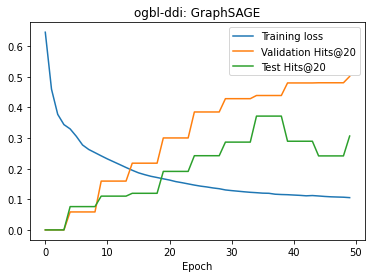

In [ ]:
import matplotlib.pyplot as plt

epochs_bar = trange(1, epochs + 1, desc='Loss n/a')

edge_index = ddi_graph.edge_index.to(device)
pos_train_edges = train_edges['edge'].to(device)

losses = []
valid_hits_list = []
test_hits_list = []
for epoch in epochs_bar:
    loss = train(graphsage_model, link_predictor, initial_node_embeddings.weight, edge_index, pos_train_edges, optimizer, batch_size)
    losses.append(loss)

    epochs_bar.set_description(f'Loss {loss:0.4f}')

    if epoch % eval_steps == 0:
        valid_hits, test_hits = test(graphsage_model, link_predictor, initial_node_embeddings.weight, edge_index, pos_valid_edges, neg_valid_edges, pos_test_edges, neg_test_edges, batch_size, evaluator)
        print()
        print(f'Epoch: {epoch}, Validation Hits@20: {valid_hits["hits@20"]:0.4f}, Test Hits@20: {test_hits["hits@20"]:0.4f}')
        valid_hits_list.append(valid_hits['hits@20'])
        test_hits_list.append(test_hits['hits@20'])
    else:
        valid_hits_list.append(valid_hits_list[-1] if valid_hits_list else 0)
        test_hits_list.append(test_hits_list[-1] if test_hits_list else 0)

plt.title(dataset.name + ": GraphSAGE")
plt.xlabel("Epoch")
plt.plot(losses, label="Training loss")
plt.plot(valid_hits_list, label="Validation Hits@20")
plt.plot(test_hits_list, label="Test Hits@20")
plt.legend()
plt.show()

Our model performed well! 
There is some randomness in initial embeddings and the data loader. In our run, our final Validation Hits@20 is 0.50, and Test Hits@20 is 0.40. Further improvements that could be made include:
* Training for longer (we set a small number of epochs by default to reduce the time spent waiting for results)
* Exploring gradient clipping, weight initialization distributions, and whether normalization of node embeddings helps in the `SAGEConv` layer. Some of these are explored in Hu et al. (2020) ([paper](https://arxiv.org/abs/2005.00687), [code](https://github.com/snap-stanford/ogb/tree/master/examples/linkproppred/ddi)) to obtain strong results.

We will move on though to showing how we can modify the GraphSAGE operator to include other graph attributes that gives our model more information to learn from.

# Defining A Custom GraphSAGE Operator

The DDI graph given to us didn't have any node or edge features, but we can augment the data we input into the model by calculating our own metrics. The paper that is currently at the top of the OGB DDI leaderboard by Yang and Lu (2021) ([paper](https://github.com/lustoo/OGB_link_prediction/blob/main/Link%20prediction%20with%20structural%20information.pdf), [code](https://github.com/lustoo/OGB_link_prediction)) makes a modification to the standard GraphSAGE operator from Equation (2) [4]. They define an **edge attribute** (a value associated with every edge) that for every edge, calculates the average distance between the two nodes and a set of **anchor nodes** sampled from the graph. We will implement a scaled-down version of the author's approach here (due to Colab GPU's default memory and runtime restrictions) to demonstrate how it is possible to define your own graph convolutional layers in PyG.   


For every edge $(u, v)$, we calculate the average distance to the set of anchor nodes. Let the set of anchor nodes be $V_A \in V$. We can define this distance as follows:
$$\text{anchor_d}_{u, v} = \frac{1}{|V_A|}\sum_{v_a \in V_A} d_{u, v_a} + d_{v, v_a}$$
where $d_{u, v}$ is the shortest path between $u$ and $v$.

The [NetworkX library](https://networkx.org/documentation/stable/index.html) defines functions that calculate shortest paths in networks. We use the PyG utility function to convert `ddi_graph` to a NetworkX undirected graph. 

In [ ]:
from torch_geometric.utils import to_networkx

nx_ddi_graph = to_networkx(ddi_graph, to_undirected=True)

/usr/local/lib/python3.7/dist-packages/torch_geometric/data/storage.py:264: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  " to suppress this warning")


We start with a default of 200 anchor nodes that we will sample from `nx_ddi_graph`, but we also make this configurable, so feel free to try other values.

In [ ]:
#@title Anchor nodes parameters
num_anchor_nodes = 200 #@param {type: 'number'}

We now calculate the shortest paths from every anchor node to every other node using NetworkX's `single_source_shortest_path_length` function.

We follow the Yang and Lu (2021) ([paper](https://github.com/lustoo/OGB_link_prediction/blob/main/Link%20prediction%20with%20structural%20information.pdf), [code](https://github.com/lustoo/OGB_link_prediction)) method of limiting the maximum shortest path length to 5.
This cell takes around 1 minute to complete.

In [ ]:
import numpy as np
import networkx as nx

# Sample anchor nodes
anchor_nodes = np.random.choice(nx_ddi_graph.number_of_nodes(), size=num_anchor_nodes, replace=False)

# This tensor with shape [|V|, |V_A|] will hold our computed shortest path distances
shortest_paths_to_anchor_nodes = torch.zeros(nx_ddi_graph.number_of_nodes(), num_anchor_nodes)
for anchor_index, anchor_node in enumerate(anchor_nodes):
    for dst, path_length in nx.single_source_shortest_path_length(nx_ddi_graph, source=anchor_node, cutoff=5).items():
        shortest_paths_to_anchor_nodes[dst, anchor_index] = path_length

print(f'Shortest paths for node 0 to every anchor node: {shortest_paths_to_anchor_nodes[0]}')

Shortest paths for node 0 to every anchor node: tensor([2., 2., 3., 3., 2., 2., 2., 3., 1., 2., 2., 2., 3., 2., 2., 2., 1., 1.,
        2., 2., 2., 2., 2., 2., 2., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1.,
        2., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 1., 3., 1., 2., 2.,
        2., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 3., 2.,
        1., 3., 2., 2., 2., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 2.,
        2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 3., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 2.,
        2., 2., 2., 2., 2., 2., 3., 2., 1., 2., 1., 2., 2., 2., 2., 3., 2., 3.,
        2., 2., 1., 1., 2., 2., 1., 3., 2., 2., 2., 2., 2., 3., 3., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 3., 2., 1., 2., 3., 2., 1., 2., 2., 2., 1., 2.,
        2., 2., 1., 3., 2., 2., 2., 3., 2., 3., 2., 2., 2., 1., 2., 2., 2., 2.,
        2., 2.])


Now for every edge, we add together $d_{u, v_a}$ and $d_{v, v_a}$ for every anchor node $v_a \in V_A$, and then take the average of these summed distances. We further follow the Yang and Lu (2021) ([paper](https://github.com/lustoo/OGB_link_prediction/blob/main/Link%20prediction%20with%20structural%20information.pdf), [code](https://github.com/lustoo/OGB_link_prediction)) approach of normalizing the computed anchor distances to the range $[0, 1]$. The result is a tensor of shape $[|E|, 1]$.

In [ ]:
# shortest_paths_to_anchor_nodes[ddi_graph.edge_index, :] creates a tensor of shape [2, |E|, |V_A|]
# The tensor at position 0 along dimension 0 contains the anchor node distances for the source node,
# and the tensor at position 1 contains the anchor node distances for the destination node
edge_attr = shortest_paths_to_anchor_nodes[ddi_graph.edge_index, :].sum(dim=0).mean(dim=1, keepdim=True).to(device)
# Normalize to range [0, 1]
max_attr = torch.max(edge_attr)
min_attr = torch.min(edge_attr)
edge_attr = (edge_attr - min_attr) / (max_attr - min_attr + 1e-15)

Now that we have our edge attributes tensor, we want to incorporate it into the GraphSAGE convolution operator to take advantage of it. Recall Equation (2) for the standard GraphSAGE layer:

$$h_v^{(l + 1)} = W_1 \cdot h_v^{(l)} + W_2 \cdot \text{mean}(\{h_u^{(l)}, \forall u \in N(v)\})$$

Yang and Lu (2021) ([paper](https://github.com/lustoo/OGB_link_prediction/blob/main/Link%20prediction%20with%20structural%20information.pdf), [code](https://github.com/lustoo/OGB_link_prediction)) modify the message passed by each neighbor $u$ along the edge $(u, v)$ to include the edge attribute value, scaled by a learnable weight matrix and passed through a nonlinearity:

$$h_v^{(l + 1)} = W_1 \cdot h_v^{(l)} + W_2 \cdot \text{mean}(\{\text{ReLU}(h_u^{(l)} + W_3 \cdot \text{edge_attr}_{u, v}), \forall u \in N(v)\})$$
$$\text{Equation } (3)$$

The message function has become $m_{u \rightarrow v}^{(l + 1)} = h_u^{(l)} + W_3 \cdot \text{edge_attr}_{u, v}$.
To implement this, we need to define our own custom version of PyG's `SAGEConv`, since this doesn't have the edge attribute aspect.

PyG provides `torch_geometric.nn.conv.MessagePassing` as the base class that we can extend to define our own operator. The advantage of this is that `MessagePassing` takes care of propagating messages throughout the network for us, we just have to define what the message is, and how to aggregate and update embeddings.

PyG provides [full documentation and examples](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html) for this process of defining custom layers.

Due to Colab GPU memory limits, we reduce the size of our parameters:

In [ ]:
graphsage_in_channels = 128
graphsage_hidden_channels = graphsage_in_channels
graphsage_out_channels = graphsage_hidden_channels
link_predictor_in_channels = graphsage_out_channels
link_predictor_hidden_channels = link_predictor_in_channels
edge_attr_out_channels = graphsage_hidden_channels

We define `SAGEConvWithEdgeAttr` to implement Equation (3). 

In [ ]:
from torch_geometric.nn.conv import MessagePassing

class SAGEConvWithEdgeAttr(MessagePassing):
    """Custom GraphSAGE operator that includes edge attributes."""
    def __init__(self, in_channels, out_channels, aggr='mean',
                comb=lambda x, y: x + y, normalize=True, **kwargs):
        super(SAGEConvWithEdgeAttr, self).__init__(aggr=aggr)

        # W_1 in Equation (3)
        self.w_self_embedding = torch.nn.Linear(in_channels, out_channels)
        # W_2 in Equation (3)
        self.w_aggregation = torch.nn.Linear(in_channels, out_channels)
        # W_3 in Equation (3)
        self.w_edge_attr = torch.nn.Linear(1, edge_attr_out_channels)

        self.comb = comb
        self.normalize = normalize

    def forward(self, x, edge_index, edge_attr, size=None):

        # Starts propagating messages through the network
        # Passing edge_attr here makes it available in the message() function
        # The second argument to propagate is x = (x_i, x_j), where x_i is features
        # of the source nodes and x_j is features of the destination nodes (Recall
        # that both (i, j) and (j, i) are in edge_index). We don't distinguish
        # between source and destination nodes in this graph, so we just pass x=(x,x)
        aggregations = self.propagate(edge_index, x=(x, x), edge_attr=edge_attr, 
                                        size=size)
        out = self.w_self_embedding(x) + self.w_aggregation(aggregations)

        if self.normalize:
            out = F.normalize(out)

        return out

    def message(self, x_j, edge_attr):
        """Define our custom message."""
        # We are given x_j here because we are essentially defining what message
        # the destination (x_j) should pass to the source (x_i). The actual passing
        # is handled by PyG.
        return F.relu(self.comb(x_j, self.w_edge_attr(edge_attr)))

We are ready to set up a model that uses our new operator. Since we now have edge attributes, the `forward_with_edge_attr` function will be used in our `GraphSAGE` class.

In [ ]:
initial_node_embeddings = torch.nn.Embedding(ddi_graph.num_nodes, graphsage_in_channels).to(device)
graphsage_model = GraphSAGE(SAGEConvWithEdgeAttr, graphsage_in_channels, 
                                 graphsage_hidden_channels,
                                 graphsage_out_channels,
                                 graphsage_num_layers, 
                                 dropout).to(device)
link_predictor = LinkPredictor(link_predictor_in_channels, link_predictor_hidden_channels, dropout).to(device)                                

/usr/local/lib/python3.7/dist-packages/torch_geometric/data/storage.py:264: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  " to suppress this warning")


In [ ]:
optimizer = torch.optim.Adam(list(initial_node_embeddings.parameters()) + list(graphsage_model.parameters()) + list(link_predictor.parameters()), lr=lr)

Run training and evaluation. The following cell takes around 15 minutes to run.

Loss 0.3724:  10%|█         | 5/50 [01:23<13:03, 17.41s/it]


Epoch: 5, Validation Hits@20: 0.0205, Test Hits@20: 0.0347


Loss 0.2990:  20%|██        | 10/50 [02:49<11:39, 17.50s/it]


Epoch: 10, Validation Hits@20: 0.1720, Test Hits@20: 0.0971


Loss 0.2562:  30%|███       | 15/50 [04:14<10:13, 17.51s/it]


Epoch: 15, Validation Hits@20: 0.1861, Test Hits@20: 0.1103


Loss 0.2370:  40%|████      | 20/50 [05:40<08:46, 17.55s/it]


Epoch: 20, Validation Hits@20: 0.1381, Test Hits@20: 0.1236


Loss 0.2253:  50%|█████     | 25/50 [07:06<07:22, 17.69s/it]


Epoch: 25, Validation Hits@20: 0.1993, Test Hits@20: 0.1248


Loss 0.2116:  60%|██████    | 30/50 [08:34<05:55, 17.78s/it]


Epoch: 30, Validation Hits@20: 0.1949, Test Hits@20: 0.1391


Loss 0.2036:  70%|███████   | 35/50 [10:00<04:25, 17.70s/it]


Epoch: 35, Validation Hits@20: 0.1428, Test Hits@20: 0.1078


Loss 0.1981:  80%|████████  | 40/50 [11:27<02:57, 17.73s/it]


Epoch: 40, Validation Hits@20: 0.2002, Test Hits@20: 0.1590


Loss 0.1919:  90%|█████████ | 45/50 [12:53<01:29, 17.81s/it]


Epoch: 45, Validation Hits@20: 0.1992, Test Hits@20: 0.1538


Loss 0.1891: 100%|██████████| 50/50 [14:20<00:00, 17.21s/it]


Epoch: 50, Validation Hits@20: 0.1918, Test Hits@20: 0.1175


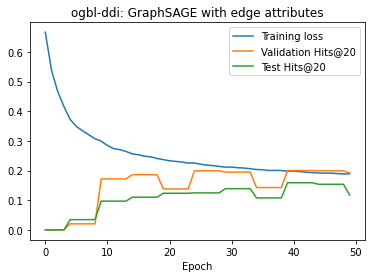

In [ ]:
epochs_bar = trange(1, epochs + 1, desc='Loss n/a')

losses = []
valid_hits_list = []
test_hits_list = []
for epoch in epochs_bar:
    loss = train(graphsage_model, link_predictor, initial_node_embeddings.weight, edge_index, pos_train_edges, optimizer, batch_size, edge_attr)
    losses.append(loss)

    epochs_bar.set_description(f'Loss {loss:0.4f}')

    if epoch % eval_steps == 0:
        valid_hits, test_hits = test(graphsage_model, link_predictor, initial_node_embeddings.weight, edge_index, pos_valid_edges, neg_valid_edges, pos_test_edges, neg_test_edges, batch_size, evaluator, edge_attr)
        print()
        print(f'Epoch: {epoch}, Validation Hits@20: {valid_hits["hits@20"]:0.4f}, Test Hits@20: {test_hits["hits@20"]:0.4f}')
        valid_hits_list.append(valid_hits['hits@20'])
        test_hits_list.append(test_hits['hits@20'])
    else:
        valid_hits_list.append(valid_hits_list[-1] if valid_hits_list else 0)
        test_hits_list.append(test_hits_list[-1] if test_hits_list else 0)

plt.title(dataset.name + ": GraphSAGE with edge attributes")
plt.xlabel("Epoch")
plt.plot(losses, label="Training loss")
plt.plot(valid_hits_list, label="Validation Hits@20")
plt.plot(test_hits_list, label="Test Hits@20")
plt.legend()
plt.show()

Your results will vary. In our run, our final results are Validation Hits@20 is 0.29  and Test Hits@20 is 0.17. To be able to fit in Colab time resource restraints, we had to reduce the number of parameters in our model and train for a shorter duration while trying to learn another weight matrix, which could explain why this model didn't perform as well as the standard GraphSAGE did after 50 epochs. Nevertheless, we have successfully defined a custom GNN layer that demonstrates how we can utilize other graph properties to help with our machine learning task.

# Summary

Congratulations on completing the Colab! We have learned a lot:

* First we learned how to load data from OGB
* We utilized PyG's `SAGEConv` operator to build a GraphSAGE GNN and combined it with a neural network for link prediction
* We then defined our own version of a GraphSAGE layer where we added edge attributes to the model

We encourage you to explore the papers referred to in this Colab, and to take a look at other OGB datasets and graph learning tasks. There is a wide variety of problems that can be solved with Graph Neural Networks!

# References
[1] "Link Property Prediction." Open Graph Benchmark, https://ogb.stanford.edu/docs/linkprop/#ogbl-ddi

[2] Hamilton, William L., et al. "Inductive Representation Learning on Large Graphs." ArXiv.org, 10 Sept. 2018, https://arxiv.org/abs/1706.02216

[3] Hu, Weihua, et al. "Open Graph Benchmark: Datasets for Machine Learning on Graphs." ArXiv.org, 2 May 2020, https://arxiv.org/abs/2005.00687

[4] Lu, Shitao, and Yang, Jing. "Link Prediction With Structural Information." https://github.com/lustoo/OGB_link_prediction/blob/main/Link%20prediction%20with%20structural%20information.pdf